In [2]:
%load_ext autoreload
%autoreload 1

import sys
HOME='/mnt/home/llorente/'
#HOME='/home/cj/'
sys.path.append(HOME+'comp_structure_research')
sys.path.append(HOME+'comp_structure_research/stellar_mass_fraction')


In [ ]:
import yt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Stellar Mass fraction analysis for the Big Box 25 Mpc simulation at z = 0
![density](imgs/RD0265_Projection_x_density.png)
![density_w_temperature](imgs/RD0265_Projection_x_density_temperature.png)
![metallicity](imgs/RD0265_Projection_x_density_metallicity.png)
![temperature](imgs/RD0265_Projection_x_temperature.png)
![metallicity](imgs/RD0265_Projection_x_metallicity.png)

In [4]:
%aimport HaloData
from HaloData import HaloData

dataset_fname  = "~/cosmo_bigbox/25Mpc_512/RD0265/RD0265"
halo_dat_fname = "halodata_RD0265.dat"
hd = HaloData.load_from_file(halo_dat_fname)


In [3]:
def DarkMatter(pfilter, data):
    filter = data[("all", "particle_type")] == 1 # DM = 1, Stars = 2
    return filter
    
yt.add_particle_filter("dark_matter", function=DarkMatter, filtered_type='all', \
                    requires=["particle_type"])

def stars(pfilter, data):
    filter = data[("all", "particle_type")] == 2 # DM = 1, Stars = 2
    return filter

yt.add_particle_filter("stars", function=stars, filtered_type='all', \
                       requires=["particle_type"])

ds = yt.load(dataset_fname)
ds.add_particle_filter('stars')
ds.add_particle_filter('dark_matter')
ad = ds.all_data()
(ad.right_edge-ad.left_edge).to('Mpc')

yt : [INFO     ] 2020-05-19 13:08:17,507 Parameters: current_time              = 639.44480440499
yt : [INFO     ] 2020-05-19 13:08:17,508 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2020-05-19 13:08:17,509 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-05-19 13:08:17,510 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-05-19 13:08:17,511 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2020-05-19 13:08:17,511 Parameters: current_redshift          = 0
yt : [INFO     ] 2020-05-19 13:08:17,512 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2020-05-19 13:08:17,513 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2020-05-19 13:08:17,513 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|██████████| 163180/163180 [00:18<00:00, 8808.35it/s] 
yt : [INFO     ] 2020-05-19 13:08:43,199 Gathering a field list (this may take a moment.)


YTArray([35.97122302, 35.97122302, 35.97122302]) Mpc

# Stellar Mass Fraction for 25 Mpc Box at z = 0

In [4]:
ds.current_redshift

0

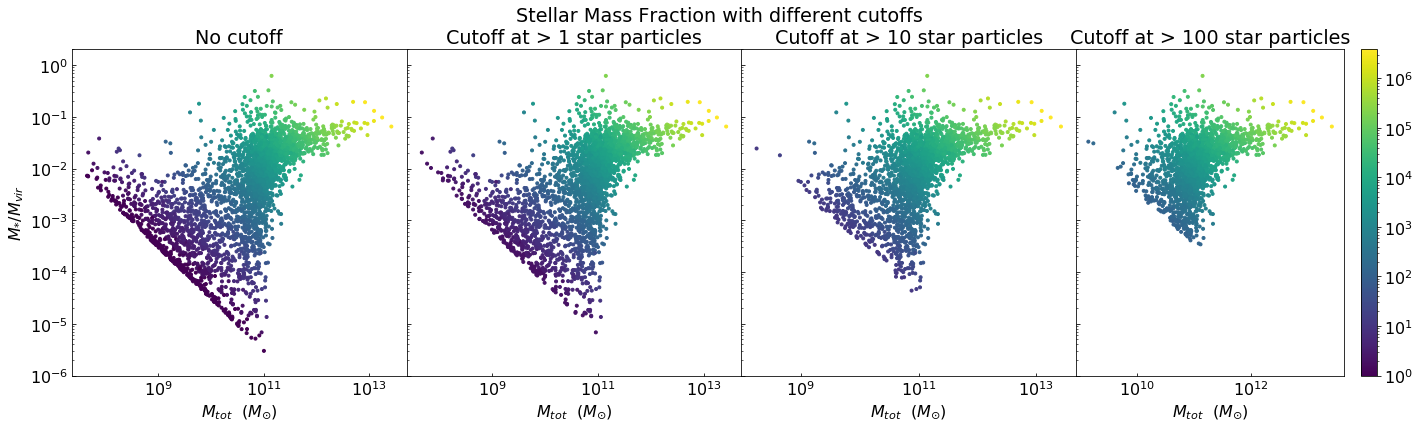

In [5]:

%aimport stellar_mass_fraction_plots
from stellar_mass_fraction_plots import *
#stellar_mass_fraction_scatter(halo_dat2_fname, cutoff=0)
stellar_mass_fraction_scatter_multi(hd)
#interact(stellar_mass_fraction_scatter, hd=fixed(hd), cutoff=(0, 1e3));

Stellar Mass Fraction of each halo, plotted against their total mass. The color represents the total number of star particles in each halo. 

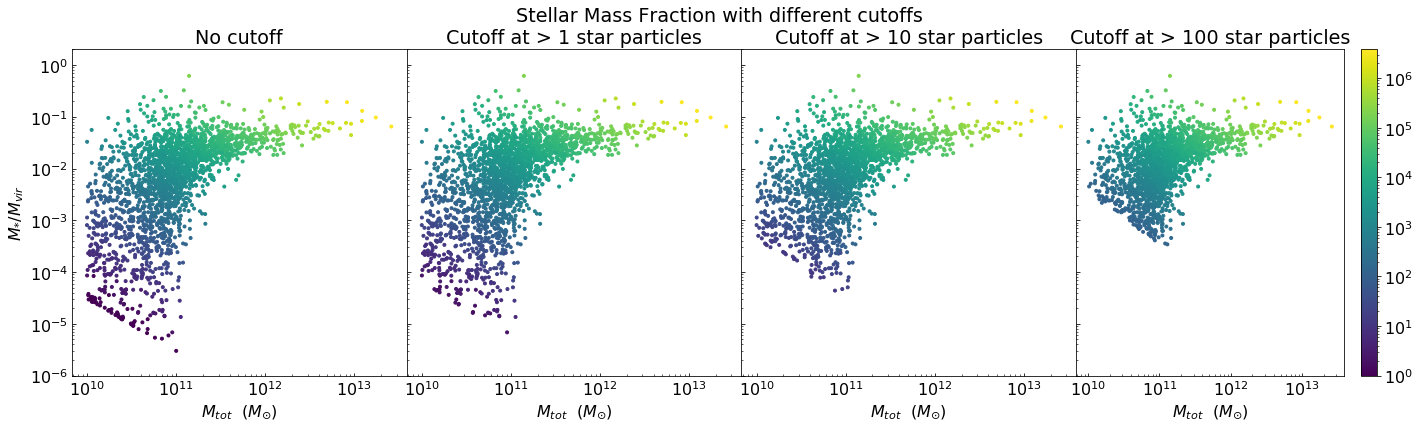

In [6]:
%aimport stellar_mass_fraction_plots
from stellar_mass_fraction_plots import *
stellar_mass_fraction_scatter_multi(hd, 1e10)

Same as the above except that halos with mass less than a certain mass have been excluded. 



# Too many stars?
<s>Not sure why some halos have a stellar mass fraction greater than 1. It might be a dataset mismatch. If it's a dataset mismatch, why are there clear trends to be seen in the graphs? You'd expect it to be basically random.</s> 

Adjusting for cosmological averages gives a stellar mass fraction higher than 1. Behroozi does not calculate stellar mass fractions this way.

<s>It's hard to keep track of which halo catalogs belong to which Enzo dataset. I need to try to figure out some way to keep track of which datasets correspond to which halo catalogs.<s> 
    
There is a file in the rockstar_halos called `datasets.txt` which contains filename of the dataset used to create the catalog.



# Data Resolution
It should make sense that the star particle cutoff results in clean, diagonal cuts on the left side of the graph. It might help to plot the stellar mass vs halo mass with number of star particles as well next to this graph just to help me make sense of things. It might be worth looking into doing a vertical cut at ~$10^{10}$ stellar masses. The justification for this being that the mass resolution for these halos is low, thus the data are less trustworthy. Need to confirm this and come up with a formula to determine a proper cutoff mass. 



# Formula used to calculate stellar mass fraction:
$$
f = \frac{M_*}{\displaystyle \frac{\Omega_b}{\Omega_m} M_h}
$$

where
$M_*$ is total stellar mass in a halo

$\Omega_b$ is the cosmological baryon fraction

$\Omega_c$ is the cosmological (cold) dark matter fraction

$\Omega_m = \Omega_b + \Omega_c$

$M_h$ is the halo mass. Note: make sure we calculate halo mass the same way Behroozi does in Behroozi et al (2013)


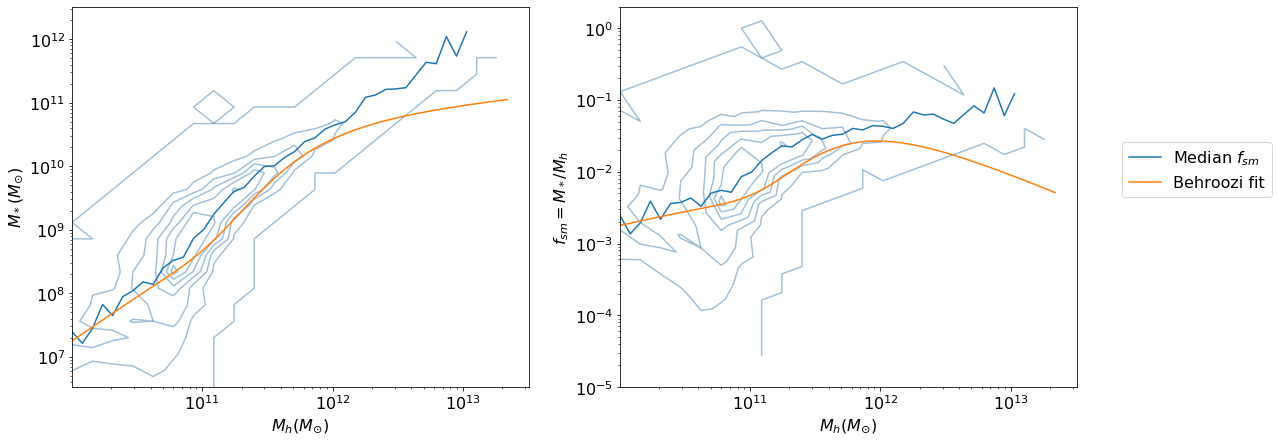

In [54]:
%aimport stellar_mass_fraction_plots
from stellar_mass_fraction_plots import *
stellar_mass_fraction_reduced(hd, 0, min_nstar=10, min_halo_mass=1e10)

Median values for stellar mass and stellar mass fraction compared to Behroozi fit function at $z=0$. 


The overall trend seems to match expectations in the mass range where the simulation is well-resolved (although I still need to quantify what "well-resolved" means), but there's an obvious gap in between the Enzo median and Behroozi's median. One good place to check is how the halo mass is being calculated. Currently I'm using rockstar's halo virial mass as the halo mass and since rockstar was written by Behroozi I'd expect that the definition of halo mass is basically the same, but its worth checking out regardless, just to make sure. 

<s>The gap might also be explained by the different redshifts. The trend in Behroozi's data has the curve moving steadily towards the right over time until $z=3.00$ at which point the curve moves back towards the right.</s> 

The gap is not explained by the different redshifts, there is virtually no difference between the fits at $z=0$ vs $z=0.1$

<s>I think with some effort I could fit Behroozi's scale parameter to his data and generate a fit for the actual redshift value, although this might not be all that accurate if the scale parameter changes depending on redshift. The other way to determine if redshift is primarily responsible for the gap (at least to first order) is to determine an average star formation rate and multiply by the time difference. That should give a reasonable estimate. <s>
    
The scale factor in Behroozi's paper is the cosmological scale factor given by
    $$
    a = \frac{1}{1+z}
    $$

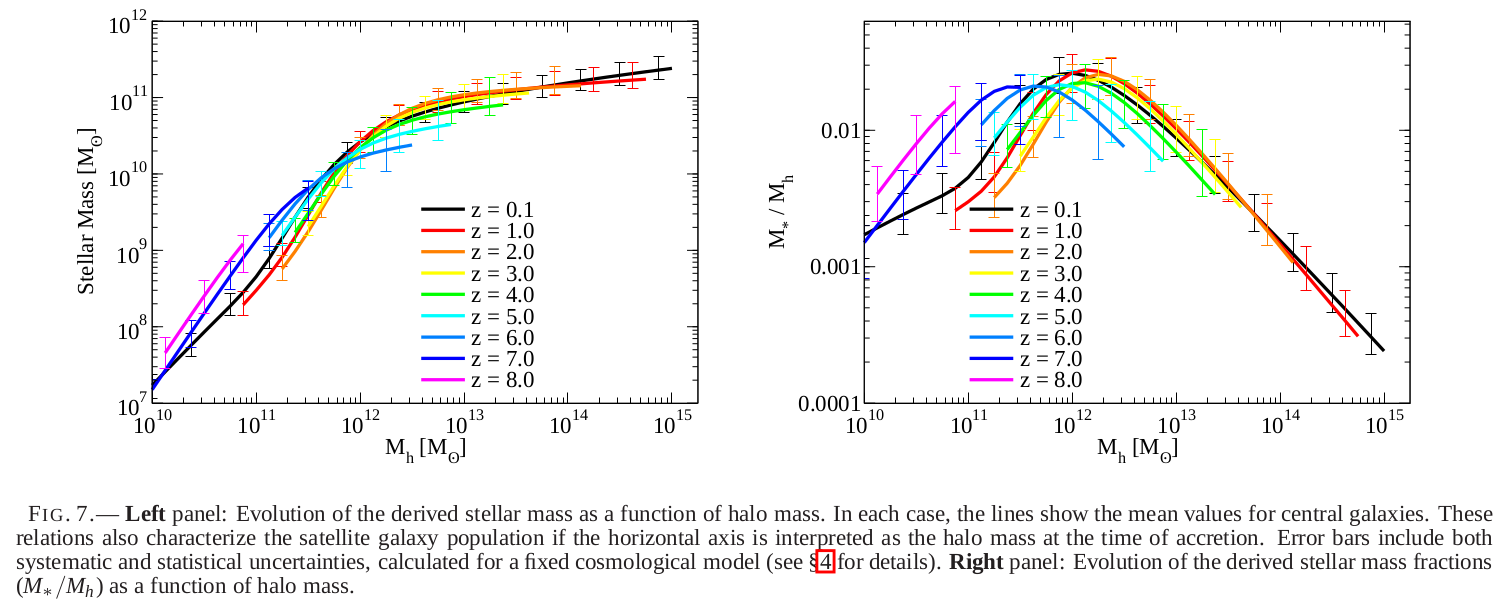

Behroozi describes his fit function as giving the *median* stellar mass for a given halo mass, but the caption in the image says that it gives the *mean* stellar mass. The data files themselves don't say one way or the other.

# Baryon Budget

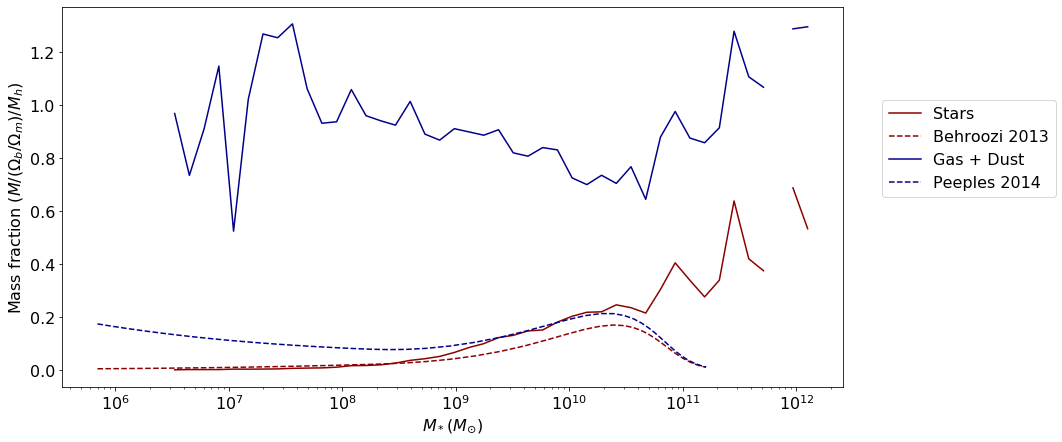

In [20]:
%aimport stellar_mass_fraction_plots
from stellar_mass_fraction_plots import *

baryon_frac(hd, 0, min_nstar=10, min_halo_mass=1e10)

Peeples 2014 is an accounting of ISM gas and this selection includes all gas in the CGM, which is why the gas count appears so high. 

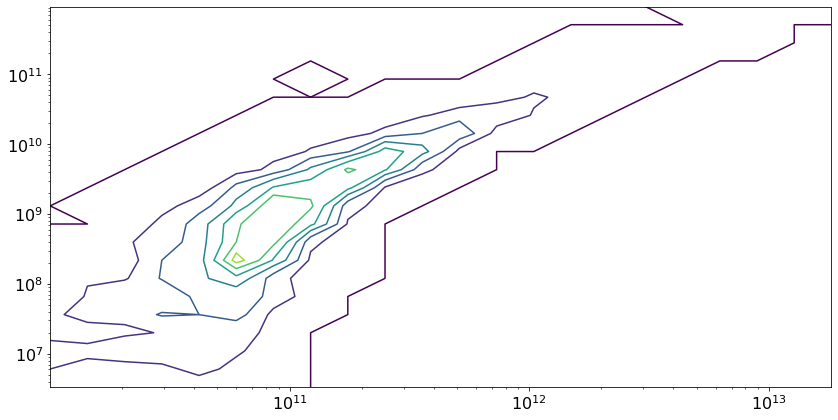

In [50]:
%aimport stellar_mass_fraction_plots
from stellar_mass_fraction_plots import *

hist_2d(hd, 0, min_nstar=10, min_halo_mass=1e10)